# Modeling Walkthrough II - Predicting the Proportion of Votes 

### Introduction

In this notebook, we are going to predict the proportion of votes attained by each party in each constituency. We will be incorporating a few more features into our model fit and using some data that has been preprocessed and can be found in the *data* folder of the [Github repository](https://github.com/MangoTheCat/rss-2018-hackathon). This type of prediction requires regression and as such we are going to use a Linear Regressor.

We start by importing the following packages. We will use **pandas** to import and manipulate our data, **seaborn** to visualise our data, **sklearn** to fit our model and **numpy** to evaluate our model. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, model_selection

# Setup
%matplotlib inline
sns.set_context('talk')
pd.set_option('display.max_columns', None)

### Importing and Exploring

First, we import our model ready data and have a look at what we are dealing with.

In [2]:
df = pd.read_csv('../../data/ge_2010_2015_training_data.csv')
df.head(15)

,Press Association Reference,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,con,grn,lab,ld,ukip,Region_East Midlands,Region_Eastern,Region_London,Region_North East,Region_North West,Region_Northern Ireland,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and the Humber,won_here_last
0,1.0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1.0,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1.0,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,2.0,Aberconwy,Wales,44593.0,29966,con,10734.0,0.358206,con,0.338182,-0.062021,0.335990,con,con,0.415052,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6,2.0,Aberconwy,Wales,44593.0,29966,lab,7336.0,0.244811,con,0.337273,0.163400,0.284813,con,con,0.282407,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,2.0,Aberconwy,Wales,44593.0,29966,ld,5786.0,0.193085,con,0.090000,-0.609159,0.075466,con,con,0.046139,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,2.0,Aberconwy,Wales,44593.0,29966,ukip,632.0,0.021091,con,0.127273,3.109344,0.086668,con,con,0.114999,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
9,2.0,Aberconwy,Wales,44593.0,29966,grn,0.0,0.000000,con,0.048182,4.008203,0.000000,con,con,0.024114,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


From this we can see that for each constituency we have five rows defined by the *party* that is being represented.  For example, in the constituency of Aberavon the Conservatives obtained 4411 votes (column *votes_last*) in the 2010 general election. This was 14% of the total number of votes (column *pc_last*) in that constituency. We also see that Labour won the seat in the 2010 general election (column *win_last* and translated to a 0/1 column in *won_here_last*) and won it again in the 2015 general election (column *actual_win_now*). They did so by a vote share of 49% (column *actual_pc_now*). The dataset also includes average vote share figures based on national polling data. So for the 2015 general election polls suggested the Conservatives would get a 33% vote share on a national level.

## Swing or no Swing?

The [Uniform National Swing](https://en.wikipedia.org/wiki/Uniform_national_swing) (UNS) is a commonly used method to predict election outcomes. It uses national polling data and the previous election results to calculate a proportional change in vote share (swing) which is then applied to the constituency level vote share. The above dataset already includes these calculations: column *swing_now* is the proportional change in vote share on a national level,  column *swing_forecast_pc* is the prediction for the constituency level vote share and based on that column *swing_forecast_win* is a prediction of who will win the seat.      

Note that UNS assumes that the data for each party in each constituency is independent of each other. Nevertheless it still produces a reasonably accurate result as we will see now. We do this by comparing *swing_forecast_win* with *actual_win_now* to get an aggregate view of the accuracy and *swing_forecast_pc* with *actual_pc_now* to get average error per seat.


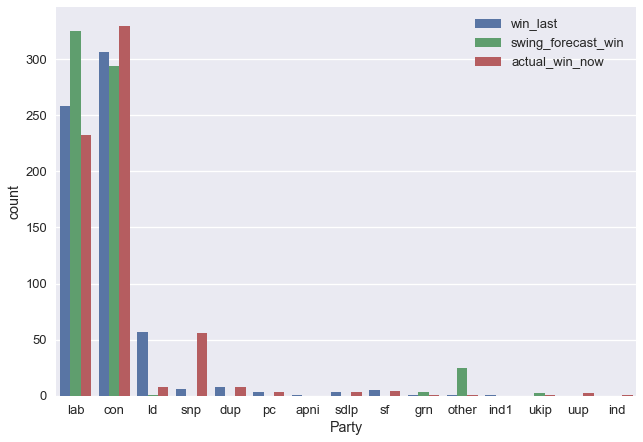

In [3]:
prediction_data = df[['Constituency Name', 'win_last', 'swing_forecast_win', 'actual_win_now']]

prediction_data = prediction_data.drop_duplicates(['Constituency Name'])

prediction_data = pd.melt(prediction_data, id_vars='Constituency Name',
                          value_vars=['win_last', 'swing_forecast_win', 'actual_win_now'], 
                          var_name="Type", value_name="Party")

prediction_data["Party"] = prediction_data["Party"].str.lower()

p = sns.countplot(x='Party', hue='Type', data=prediction_data)
p.legend(loc=1)

Next, we calculate the difference in proportion of votes actually attained and the proportion stated in *swing_forecast_pc*. 

In [4]:
np.mean(abs(df['actual_pc_now'] - df['swing_forecast_pc']))

0.044484066758131297

So the prediction through UNS is not that bad but there is still room for improvement. And we can improve by adding more features to the model, which we will do next.

## Adding features
Now, we are going to use `seaborn` to visualise the relationships between our features. Using this, we can see how useful they are going to be to our model.

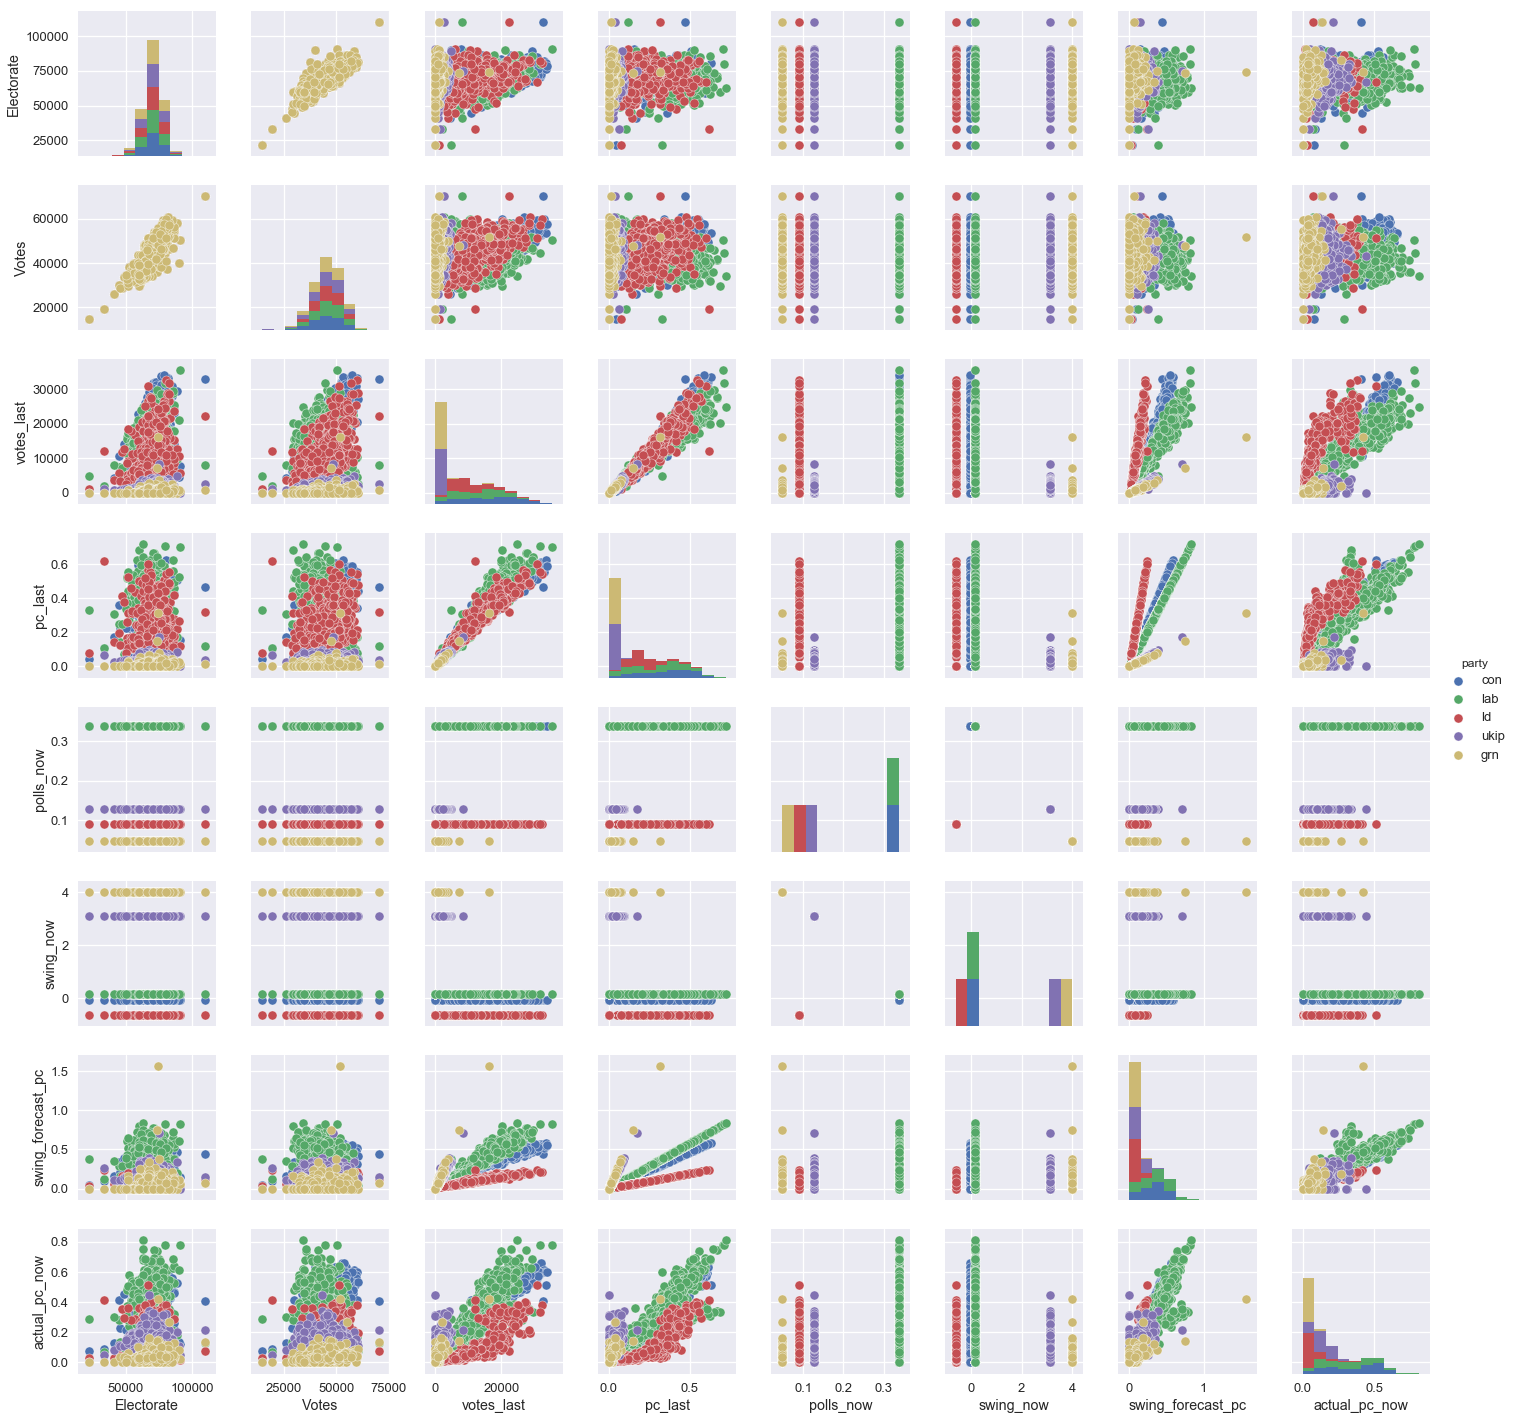

In [5]:
sns.pairplot(df[['Electorate', 'Votes', 'votes_last', 'pc_last', 'polls_now', 'swing_now', 'swing_forecast_pc', 'actual_pc_now', 'party']],
             hue='party')

Our target variable is *actual_pc_now*, the vote share for the 2015 general election. Looking at which variables correlate highly with it we see that *votes_last* and *pc_last* are good candidates. As is *swing_forecast_pc* but that should not come as a surprise given the results from the previous section. The columns *votes_last* and *pc_last* are also highly correlated with eachother, as are the columns *Electorate* and *Votes*.

We can use the above results to enhance the UNS model in the next section.

## Fitting our Model

In this section we are going to fit our model and calculate how accurate our model fit was by performing cross validation!

In [6]:
model = linear_model.LinearRegression()

We define the features we use below:

In [7]:
features= ['Electorate', 'Votes', 'votes_last', 'pc_last', 'won_here_last',
         'polls_now', 'swing_now', 'swing_forecast_pc', 'con', 'lab', 'grn', 'ld', 'ukip']

Now, we define a function `score_model` to help us cross validate our model using [K Fold Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29#k-fold_cross-validation). What this means is that we take our data set and do the following:

* Split it into K parts
* Train our model on K-1 of those parts
* Test our model on the last part
* Calculate the error of our model

We repeat these steps a few times and average our error.

In [8]:
# Some useful functions
def score_model(model, X, y, repeats=5):
    """Calculates a "5x5" (repeated 5-fold) cross-validated shuffled mean average error.
       Returns the mean across 5 (default) repeats."""
    mae = []
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=30082018)
    for i in range(repeats):
        mae += [-np.mean(model_selection.cross_val_score(model, X=X, y=y, cv=kfold, scoring='neg_mean_absolute_error'))]
    mean = np.mean(mae)
    return mean


Let's call the function on our model.

In [9]:
score_model(model, df[features], df['actual_pc_now'])

0.032871103297607417

So our model produces an average error of 3.3% which is an improvement over the UNS model. Of course just throwing all variables into a model isn't very sophisticated nor does it produce a model that makes sense (e.g. there might be an issue with including highly correlated variables). How to overcome these hurdles and further improve the model is the topic of the next section.

## Extensions

Now that you have followed this walk-through to get you going, try any (or all) of the following ideas for yourself:

- You can copy this Rmarkdown document and pick up where we left off by:
    - Removing highly correlated variables
    - Adding regional information
    - Creating new features

- You can add more data from other [sources](http://bit.ly/UKPoliticsDatasets) and build a completely different model
- Anything else you can think of, be creative!

**Good Luck and Have Fun!**
